# Isoholonomic problem with periodic boundary conditions

This notebook demonstrates the computation of an optimal motion path that realizes a prescribed rigid body motion (RBM) with periodic boundary condition. Ie start and end shape differ only by the rigid body motion.
For this we solve a constrained optimization of the path energy with the following constraints:

**Constraints**: 
 - horizontal constraints to satisfy geometric motion constraints
 - periodicity constraint (last shape a rigid body motion of first shape)
 - center constraint for last shape to rule out equivalent solutions given by rigid body motion of entire path
 - length constraint of first shape to rule out degenerate solution

In [1]:
import os
import numpy as np
import time
from types import SimpleNamespace
import matplotlib.pyplot as plt
from pathlib import Path

from constraints import *
from energies import *
from utils import * 

# # Get current working directory
working_dir = Path(os.getcwd())

### Define Optimization Parameters

- **K**: Number of time steps in the path (including start and end)
- **bending_weight**: Weight for bending energy (penalizes curvature)
- **membrane_weight**: Weight for membrane energy (penalizes stretching)
- **a_weight**: Isotropic dissipation coefficient
- **b_weight**: Anisotropic dissipation coefficient (negative allows easier tangential motion)

In [2]:
# Time steps of path
K = 11
num_freeShapes = K - 1  # First and last shapes are fixed

# Specify parameters
param = {
    'bending_weight': 0.001,      # Controls resistance to bending
    'membrane_weight': 1.0,        # Controls resistance to stretching
    'energy_weight': 10.0,          # Overall energy weight
    'a_weight': 1.0,               # Isotropic dissipation
    'b_weight': -0.95,             # Anisotropic dissipation (negative = easier tangential motion)
    'K': K,
    'mass_factor': None,         #allows to set vertex-wise mass, if None, it is set to 1 for all vertices
    'theta':0,                   # specify rotation degree for prescribed RBM
    'b': [0.6,0., 0.]           # specify translation for prescribed RBM
}

parameters = SimpleNamespace(**param)

print("Optimization Parameters:")
for key, value in param.items():
    print(f"  {key}: {value}")

Optimization Parameters:
  bending_weight: 0.001
  membrane_weight: 1.0
  energy_weight: 10.0
  a_weight: 1.0
  b_weight: -0.95
  K: 11
  mass_factor: None
  theta: 0
  b: [0.6, 0.0, 0.0]


In [3]:
# Define path to data
# Adjust this path based on your repository structure
data_path = working_dir.parent.parent / "data"

# Load start shape
xA, lines = read_obj_curve(data_path / 'startbvp.obj')
xA = xA[::2] #we only thake every second vertex

lines = compute_lines(xA)

N = len(xA)
print(f"Start shape has {len(xA)} vertices")
print(f"Shape dimensions: {xA.shape}")

# Create end shape by applying rigid body motion
# RBM format: [rx, ry, rz, angle, tx, ty, tz]
rbm = [0., 0., 1., 0., *parameters.b]  # Translation in x, rotation around z-axis
xB = applyRBM(xA, rbm)

parameters.center =comp_center(xB)
# Specify the plane of the 2D curves (xy-plane)
normals = np.array([0., 0., 1.])

Start shape has 8 vertices
Shape dimensions: (8, 3)


### Visualize Start and End Shapes

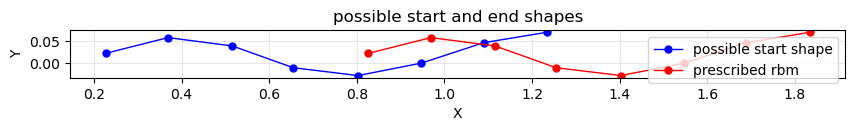

In [4]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(xA[:, 0], xA[:, 1], 'o-', linewidth=1, markersize=5, label='possible start shape', color='blue')
ax.plot(xB[:, 0], xB[:, 1], 'o-', linewidth=1, markersize=5, label='prescribed rbm', color='red')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('possible start and end shapes')
ax.set_aspect('equal', 'box')
ax.grid(True, alpha=0.3)
ax.legend()
plt.show()

We start with a simple "jumping" initialization where the first half of the path stays at shape A and the second half jumps to shape B.

In [5]:
# Reshape to correct format (flatten in Fortran order)
xA = xA.reshape(-1, order='F') 
xB = xB.reshape(-1, order='F')
xA = np.reshape(xA, (1, -1))
xB = np.reshape(xB, (1, -1))

print(f"xA shape: {xA.shape}")
print(f"xB shape: {xB.shape}")

# Initialize with constant path (jumping in the middle)
x0 = np.concatenate([int((K-1)/2) * [xA], int((K-1)/2) * [xB]])
x0 = x0.reshape(-1)

print(f"Initial path shape: {x0.shape}")
print(f"Total degrees of freedom: {len(x0)}")

xA shape: (1, 24)
xB shape: (1, 24)
Initial path shape: (240,)
Total degrees of freedom: 240


Set up the arguments and constraints for the optimization.

In [6]:
# Define parameters for energy functions
args = (
    lines, normals,
    parameters.bending_weight,
    parameters.membrane_weight,
    K, xA, xB,
    parameters.energy_weight,
    parameters.a_weight,
    parameters.b_weight,
    parameters.mass_factor
)

### Unconstrained Optimization
We first minimize the path energy without constraints using Newton-CG. This gives us a good starting point for the constrained optimization.

In [7]:
print("Starting unconstrained optimization...")
print("Method: Newton-CG")
print("="*60)

start_time = time.time()

optResult = scipy.optimize.minimize(
    path_energy.pathEnergy,
    x0,
    args,
    jac=path_energy.gradientPathEnergy,
    hess=path_energy.hessianPathEnergy,
    method='Newton-CG',
    options={'maxiter': 1000, 'disp': True}
)

unconstrained_time = time.time() - start_time

print(f"\nUnconstrained optimization completed in {unconstrained_time:.2f} seconds")
print(f"Success: {optResult.success}")
print(f"Final energy: {optResult.fun:.6f}")
print(f"Iterations: {optResult.nit}")

# Use result as starting point for constrained optimization
x0 = optResult.get('x')

Starting unconstrained optimization...
Method: Newton-CG
Optimization terminated successfully.
         Current function value: 0.122374
         Iterations: 23
         Function evaluations: 25
         Gradient evaluations: 25
         Hessian evaluations: 23

Unconstrained optimization completed in 3.87 seconds
Success: True
Final energy: 0.122374
Iterations: 23


### Geodesic boundary value problem
For comparison we first compute the bvp problem with fixed xA and xB.

In [8]:
print("Starting constrained optimization for boundary value problem...")

print("="*60)
constr_horizontal = create_horizontal_constraint(
    K, xA, xB,
    parameters.a_weight,
    parameters.b_weight,
    parameters.mass_factor
)
start_time = time.time()

optResult = scipy.optimize.minimize(
    path_energy.pathEnergy,
    x0,
    args,
    jac=path_energy.gradientPathEnergy,
    hess=path_energy.hessianPathEnergy,
    method='trust-constr',
    options={'maxiter': 3000, 'disp': True},
    constraints={constr_horizontal}
)

unconstrained_time = time.time() - start_time

print(f"\nBoundary value problem completed in {unconstrained_time:.2f} seconds")
print(f"Success: {optResult.success}")
print(f"Final energy: {optResult.fun:.6f}")
print(f"Iterations: {optResult.nit}")

bvp = optResult.get('x')
# Reshape and add fixed start/end shapes
bvp = np.reshape(bvp, (num_freeShapes, -1)) 
bvp = np.concatenate((xA, bvp, xB))

# Reshape to 3D coordinates
bvp = bvp.reshape((bvp.shape[0], -1, 3), order='F')

Starting constrained optimization for boundary value problem...
`xtol` termination condition is satisfied.
Number of iterations: 160, function evaluations: 272, CG iterations: 8950, optimality: 1.90e-07, constraint violation: 2.52e-17, execution time: 1e+01 s.

Boundary value problem completed in 14.10 seconds
Success: True
Final energy: 0.826324
Iterations: 160


In [9]:
#visualize the path
animate_shape_sequence(bvp, save=False, returnHTML=True)

### Isoholonomic problem
We minimize the path energy with all constraints necessary for the isoholonomic problem. It will take around 90 seconds. We use the unconstrained minimization as initialization.

In [10]:
x0 = np.concatenate([xA.flatten(),x0, xB.flatten()])
xA = None
xB = None
K = bvp.shape[0]+1
num_freeShapes = K - 1 
args = (
    lines, normals,
    parameters.bending_weight,
    parameters.membrane_weight,
    K, xA, xB,
    parameters.energy_weight,
    parameters.a_weight,
    parameters.b_weight,
    parameters.mass_factor
)

# Define horizontal constraint (6 constraints per time step)
constr_horizontal = create_horizontal_constraint(
    K, xA, xB,
    parameters.a_weight,
    parameters.b_weight,
    parameters.mass_factor
)
#constraints last shape to be a rigid body motion of first shape with parameters theta and b
constr_periodicity = create_periodic_constraint(K, N, parameters.theta, parameters.b)
#constraint center of mass of last shape to be at specified position 
#(rule out equivalent solutions given by rigid body motion of entire path)
constr_center = create_center_constraint(K, parameters.center)
#constraints total length of first shape to one (rule out degenerate solutions)
constr_edge_length = create_edge_length_constraint_first_shape(K, bounds = [-1e-6, 1e-6])

In [11]:
print("\nStarting constrained optimization for isoholonomic problem")
print("Method: trust-constr")
print("="*60)

start_time = time.time()

optResult = scipy.optimize.minimize(
    path_energy.pathEnergy,
    x0,
    args,
    jac=path_energy.gradientPathEnergy,
    hess=path_energy.hessianPathEnergy,
    method='trust-constr',
    options={'maxiter': 2000, 'disp': True},
    constraints={constr_horizontal, constr_periodicity, 
                 constr_center, constr_edge_length}
)

constrained_time = time.time() - start_time

print(f"\nConstrained optimization completed in {constrained_time:.2f} seconds")
print(f"Success: {optResult.success}")
print(f"Final energy: {optResult.fun:.6f}")
print(f"Iterations: {optResult.nit}")

# Get optimized path
opt = optResult.get('x')

# Reshape and add fixed start/end shapes
pos = np.reshape(opt, (num_freeShapes, -1)) 

# Reshape to 3D coordinates
periodic_path = pos.reshape((pos.shape[0], -1, 3), order='F')


Starting constrained optimization for isoholonomic problem
Method: trust-constr
The maximum number of function evaluations is exceeded.
Number of iterations: 2000, function evaluations: 3865, CG iterations: 147686, optimality: 1.84e-04, constraint violation: 1.11e-16, execution time: 1.7e+02 s.

Constrained optimization completed in 168.89 seconds
Success: False
Final energy: 0.484499
Iterations: 2000


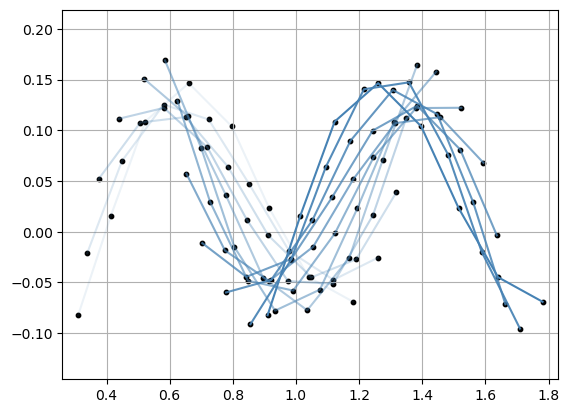

In [12]:
visualize_shape_sequence(periodic_path, save=False)

We compare the boundary value problem with fixed periodic boundray conditions and the isoholonomic problem with free periodic conditions.

In [13]:
seq = np.array([periodic_path, bvp])
animate_multi_shape_sequence(seq,labels=['periodic', 'bvp'], save=False, returnHTML=True)

As expected, the inner and outer dissipation energy of the isoholonomic path with free boundary conditions is lower than for fixed (periodic) boundary conditions.

In [14]:
en_args = ( lines, normals, parameters.bending_weight, parameters.membrane_weight, K, xA,xB)

print("Energy of isoholonomic path with free periodic boundary conditions:")
print("="*60)
print("Outer Disspiation Energy ", outer_dissipation_path_energy.outerDissipationPathEnergy(opt,K, xA, xB))
print("Inner Disspiation Energy ", inner_dissipation_path_energy.innerDissipationPathEnergy(opt, *en_args))
print("="*60)

print("Energy of boundary value problem solution:")
print("="*60)
bvpt = bvp.reshape((bvp.shape[0], -1), order='F')
bvpt = bvpt.reshape(-1) 
print("Outer Disspiation Energy ", outer_dissipation_path_energy.outerDissipationPathEnergy(bvpt,K, xA, xB))
print("Inner Disspiation Energy ", inner_dissipation_path_energy.innerDissipationPathEnergy(bvpt, *en_args))
print("="*60)

Energy of isoholonomic path with free periodic boundary conditions:
Outer Disspiation Energy  0.03642948570834939
Inner Disspiation Energy  0.1202036765927219
Energy of boundary value problem solution:
Outer Disspiation Energy  0.07493591878461954
Inner Disspiation Energy  0.22720608339234238
